이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-05-24 11:05:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.206.72, 52.216.37.136, 52.217.107.206, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.206.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.7MB/s    in 0.3s    

2023-05-24 11:05:36 (43.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**예나 날씨 데이터셋 조사하기**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()   # 파일 내용을 읽고 ,'data'변수에 저장한다. -> f.read() 함수는 파일 내용을 문자열로 반환한다.

lines = data.split("\n")   # 줄 바꿈 기준으로 나누어 리스트"lines"에 저장한다. 
header = lines[0].split(",")  #lines 리스트의 첫 번째 요소를 가져와서 쉼표(,)를 기준으로 분리하여 리스트 header에 저장합니다. 이로써 헤더(열 이름)가 리스트 형태로 저장됩니다.
lines = lines[1:]    # lines에서 첫번쨰 요소를 제외한 나머지 요소들을 저장한 것 -> 데이터줄들을 말한다.
print(header) # header를 보여준다 
print(len(lines))  #데이터 줄의 개수 

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))  # 1차원 배열을 생성한다.
raw_data = np.zeros((len(lines), len(header) - 1))  # 온도를 제외한 값을 저장하는 배열 , 2차원 배열 생성
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]  # 첫번쨰 열(날짜)을 제외환 나머지 열의 값을 가져와서 부동 소수점으로 변환 
    temperature[i] = values[1]  # 두번째 값(온도)을 저장한다
    raw_data[i, :] = values[:]  # 온도를 제외한 나머지 값들을 저장한다.

**전체 기온을 그래프로 그리기**

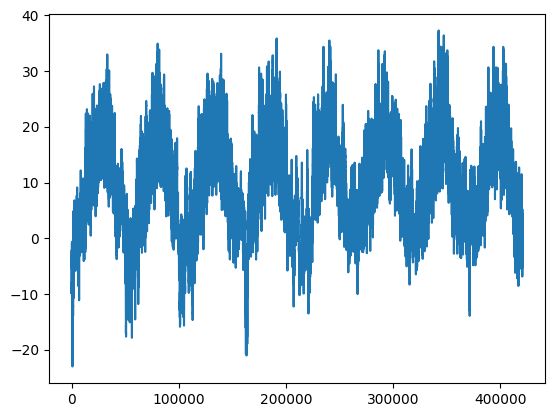

In [ ]:
from matplotlib import pyplot as plt  # pyplot 데이터를 시각화하는 함수들을 제공한다.
plt.plot(range(len(temperature)), temperature) # x축과 y축 설정해주기
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

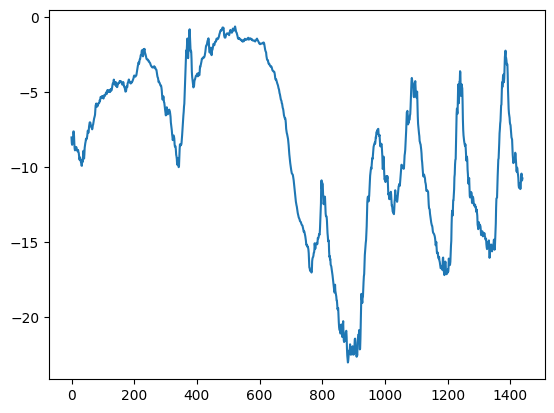

In [ ]:
plt.plot(range(1440), temperature[:1440]) # x축 ,y축 정하기
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))  # raw_data의 50퍼센트를 train에 저장하기위한 샘플 개수 
num_val_samples = int(0.25 * len(raw_data))   # 25퍼센트를 val에 저장하기 위한 개수
num_test_samples = len(raw_data) - num_train_samples - num_val_samples # 학습과 검증 데이터를 뺸것
print("num_train_samples:", num_train_samples)  
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0) 
raw_data /= std   #정규화 하는 것

In [ ]:
import numpy as np
from tensorflow import keras

# 코드해석

#keras.utils.timeseries_dataset_from_array() 함수를 사용하여 시계열 데이터셋을 생성합니다.
#data=int_sequence[:-3]는 int_sequence 배열의 처음부터 뒤에서 3번째까지의 요소를 데이터로 사용합니다. 즉, [0, 1, 2, 3, 4, 5, 6]가 입력 데이터로 사용됩니다.
#targets=int_sequence[3:]는 int_sequence 배열의 3번째 요소부터 마지막 요소까지를 타겟으로 사용합니다. 즉, [3, 4, 5, 6, 7, 8, 9]가 타겟 데이터로 사용됩니다.
#sequence_length=3은 시계열 데이터 포인트의 길이를 설정합니다. 여기서는 각 데이터 포인트가 3개의 연속된 값으로 구성됩니다.
#batch_size=2는 데이터셋의 배치 크기를 설정합니다. 여기서는 2개의 데이터 포인트로 구성된 배치가 생성됩니다.

int_sequence = np.arange(10)  #0-9까지 이루어진 배열
dummy_dataset = keras.utils.timeseries_dataset_from_array(  # timeseries_dataset_from_array ->dummy  dataset을 생성
    data=int_sequence[:-3],   # -> 0-6까지 
    targets=int_sequence[3:],   # 4번쨰 요소부터 끝까지 사용한다.  #?
    sequence_length=2,
    batch_size=5,   
)

for inputs, targets in dummy_dataset:  # input 이 data , targets -> targets이다.  즉 , timeseries 의 return값은 두개이다.
    print(f"inputs.shape={inputs.shape}, targets.shape={targets.shape}")
    for i in range(inputs.shape[0]): #input_shape[0] 이 batchsize크기이다?
        print([int(x) for x in inputs[i]], int(targets[i]))   # [int(x) for x in inputs[i]]: inputs[i]에 있는 값을 정수로 변환하여 리스트로 출력합니다. 입력 데이터 시퀀스의 모든 값들이 출력

inputs.shape=(5, 2), targets.shape=(5,)
[0, 1] 3
[1, 2] 4
[2, 3] 5
[3, 4] 6
[4, 5] 7
inputs.shape=(1, 2), targets.shape=(1,)
[5, 6] 8


In [ ]:
#교수님 추가 코드

import numpy as np
from tensorflow import keras
int_sequence = np.arange(100)
sampling_rate = 3  # sample_rate : 샘플링 속도 , 데이터 포인트 간의 간격을 나타낸다.
sequence_len = 5  
delay = sampling_rate * (sequence_len + 4 - 1)  # delay를 추가함
print(f"delay={delay}")
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-delay],  
    targets=int_sequence[delay:],
    sampling_rate = sampling_rate,
    sequence_length=sequence_len,
    batch_size=2,
    start_index = 10,  # 인덱스 10-50까지 쓰겠다.    
    end_index = 50
)

#shuffle =True를 추가할수도 있다.

for inputs, targets in dummy_dataset:
    print(f"inputs.shape={inputs.shape}, targets.shape={targets.shape}")
    for i in range(inputs.shape[0]):  # inputs.shape[0]이 batchsize 크기이다. 그래서 2개씩 나오는 것이다.
        print([int(x) for x in inputs[i]], int(targets[i]))


        #10이 14개
       #[10, 12, 14, 16, 18] 이게 120개
       # 26 이 256개이다.


delay=24
inputs.shape=(2, 5), targets.shape=(2,)
[10, 13, 16, 19, 22] 34
[11, 14, 17, 20, 23] 35
inputs.shape=(2, 5), targets.shape=(2,)
[12, 15, 18, 21, 24] 36
[13, 16, 19, 22, 25] 37
inputs.shape=(2, 5), targets.shape=(2,)
[14, 17, 20, 23, 26] 38
[15, 18, 21, 24, 27] 39
inputs.shape=(2, 5), targets.shape=(2,)
[16, 19, 22, 25, 28] 40
[17, 20, 23, 26, 29] 41
inputs.shape=(2, 5), targets.shape=(2,)
[18, 21, 24, 27, 30] 42
[19, 22, 25, 28, 31] 43
inputs.shape=(2, 5), targets.shape=(2,)
[20, 23, 26, 29, 32] 44
[21, 24, 27, 30, 33] 45
inputs.shape=(2, 5), targets.shape=(2,)
[22, 25, 28, 31, 34] 46
[23, 26, 29, 32, 35] 47
inputs.shape=(2, 5), targets.shape=(2,)
[24, 27, 30, 33, 36] 48
[25, 28, 31, 34, 37] 49
inputs.shape=(2, 5), targets.shape=(2,)
[26, 29, 32, 35, 38] 50
[27, 30, 33, 36, 39] 51
inputs.shape=(2, 5), targets.shape=(2,)
[28, 31, 34, 37, 40] 52
[29, 32, 35, 38, 41] 53
inputs.shape=(2, 5), targets.shape=(2,)
[30, 33, 36, 39, 42] 54
[31, 34, 37, 40, 43] 55
inputs.shape=(2, 5), ta

**훈련, 검증, 테스트 데이터셋 만들기**

In [ ]:
sampling_rate = 6   # 10분당 하나가 6개니까  1시간당 하나로
sequence_length = 120  # 끊어서 관찰을 하는데 , 이때 120개에 대해서
delay = sampling_rate * (sequence_length + 24 - 1) # 하루 뒤의 온도를 예측하고 싶은 것
batch_size = 256


#traindata
train_dataset = keras.utils.timeseries_dataset_from_array(  #t imeseries_dataset_from_array : 
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,  # 원래 있는 것을 쓰는 것
    sequence_length=sequence_length,
    shuffle=True,  #이 안에서는 섞을 수 있다. , 전체 다 섞는 것은 아니다.
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

#valdata
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# testdata
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [ ]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)  #(batch_size, sequence_length, num_features) 형태로 표시 ,num_features:입력데이터의 특성 개수 # 120:sequencelenght에 의해서 나온다.
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 59ms/step - loss: 13.0748 - mae: 2.7953 - val_loss: 10.6109 - val_mae: 2.5694
Epoch 2/10
819/819 [==============================] - 39s 48ms/step - loss: 8.9956 - mae: 2.3581 - val_loss: 10.2416 - val_mae: 2.5385
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 8.2251 - mae: 2.2569 - val_loss: 10.2003 - val_mae: 2.5293
Epoch 4/10
819/819 [==============================] - 47s 58ms/step - loss: 7.8313 - mae: 2.2032 - val_loss: 11.4771 - val_mae: 2.6898
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 7.5194 - mae: 2.1618 - val_loss: 10.5499 - val_mae: 2.5744
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 7.2918 - mae: 2.1300 - val_loss: 10.5035 - val_mae: 2.5672
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 7.1077 - mae: 2.1033 - val_loss: 10.5990 - val_mae: 2.5830
Epoch 8/10
819/819 [==============================] - 

**결과 그래프 그리기**

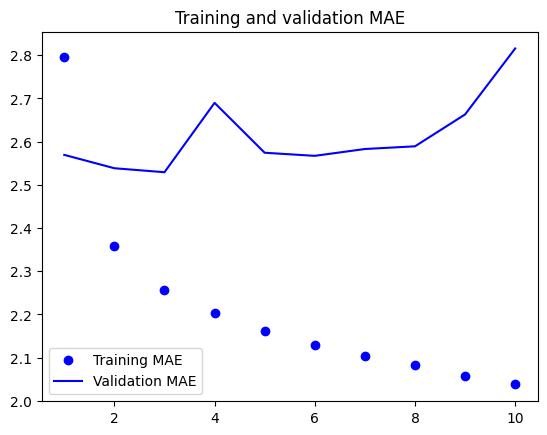

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델 시도해 보기

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 52ms/step - loss: 22.2101 - mae: 3.7126 - val_loss: 15.2695 - val_mae: 3.0717
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 15.6496 - mae: 3.1449 - val_loss: 13.9443 - val_mae: 2.9602
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 13.9810 - mae: 2.9651 - val_loss: 15.0292 - val_mae: 3.0905
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 13.1703 - mae: 2.8756 - val_loss: 14.7765 - val_mae: 3.0556
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 12.6179 - mae: 2.8132 - val_loss: 15.3843 - val_mae: 3.0893
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 12.1268 - mae: 2.7582 - val_loss: 14.0364 - val_mae: 2.9509
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 11.7192 - mae: 2.7095 - val_loss: 14.3415 - val_mae: 2.9925
Epoch 8/10
819/819 [============================

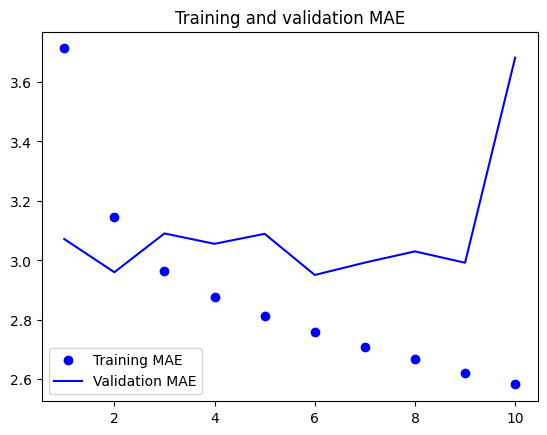

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 55ms/step - loss: 46.8021 - mae: 5.0364 - val_loss: 13.7875 - val_mae: 2.8139
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 11.9772 - mae: 2.6720 - val_loss: 9.9880 - val_mae: 2.4614
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 10.0734 - mae: 2.4789 - val_loss: 9.8797 - val_mae: 2.4431
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.6691 - mae: 2.4278 - val_loss: 10.2742 - val_mae: 2.4750
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 9.4264 - mae: 2.3949 - val_loss: 10.1531 - val_mae: 2.4629
Epoch 6/10
819/819 [==============================] - 53s 64ms/step - loss: 9.1874 - mae: 2.3621 - val_loss: 10.1136 - val_mae: 2.4629
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9930 - mae: 2.3337 - val_loss: 10.0798 - val_mae: 2.4573
Epoch 8/10
819/819 [==============================] - 

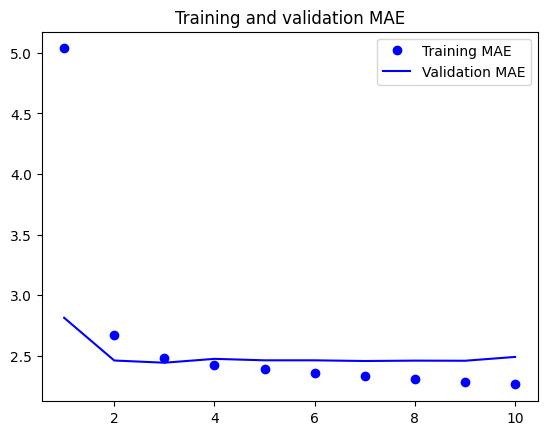

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) #nn_basic:activation이 있다.(tanh)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [ ]:
from tensorflow.keras import layers
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
model = keras.Model(inputs,outputs)
model.summary()

# (14+1) *16 +16*16 = 496

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 14)]        0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


**마지막 출력 스텝만 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120     
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)  #16개가 나오는데 , NONE은  BATCHSIZE이다.
print(outputs.shape)

(None, 16)


**전체 출력 시퀀스를 반환하는 RNN 층**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs) #TRUE라 다르다.
print(outputs.shape)

(None, 120, 16)


**스태킹(stacking) RNN 층**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)  #쌓기위해서는 TRUE를 해줘야된다.
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

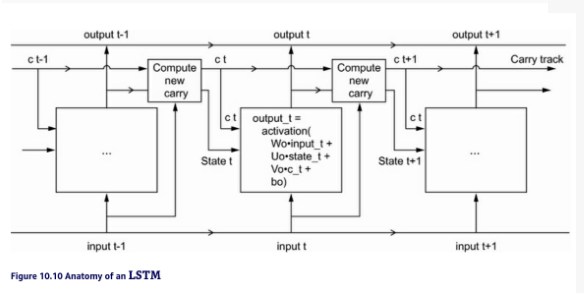
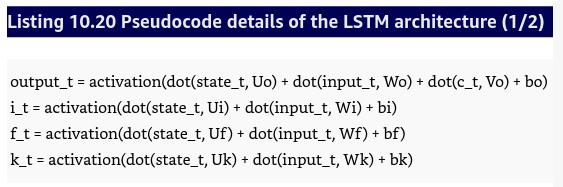

In [ ]:
# simpleRnn이랑 차이가 있다.

#recurent dropout
# bidirectional -> 양방향이 생기고 합친 결과가 나오게 된다.
# -> layers.bidrictional(layers.LSTM(16))



inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) #dropout사용방법    , unroll=True라는 방법도 있다.(rnn이 느리다 )
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)  #layer dropout사용방법
outputs = layers.Dense(1)(x)   #ouput개수는 sequence갯수 만큼 나온다.
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 55s 65ms/step - loss: 29.0184 - mae: 3.9569 - val_loss: 9.7585 - val_mae: 2.4253
Epoch 2/50
819/819 [==============================] - 45s 55ms/step - loss: 14.3286 - mae: 2.9435 - val_loss: 9.1785 - val_mae: 2.3567
Epoch 3/50
819/819 [==============================] - 50s 61ms/step - loss: 13.3250 - mae: 2.8363 - val_loss: 9.1156 - val_mae: 2.3693
Epoch 4/50
819/819 [==============================] - 45s 54ms/step - loss: 12.6680 - mae: 2.7622 - val_loss: 9.6512 - val_mae: 2.4384
Epoch 5/50
819/819 [==============================] - 54s 66ms/step - loss: 12.1900 - mae: 2.7054 - val_loss: 9.5833 - val_mae: 2.4307
Epoch 6/50
819/819 [==============================] - 44s 53ms/step - loss: 11.7516 - mae: 2.6566 - val_loss: 9.3354 - val_mae: 2.3969
Epoch 7/50
819/819 [==============================] - 44s 54ms/step - loss: 11.3862 - mae: 2.6125 - val_loss: 9.7426 - val_mae: 2.4544
Epoch 8/50
819/819 [==============================] - 5

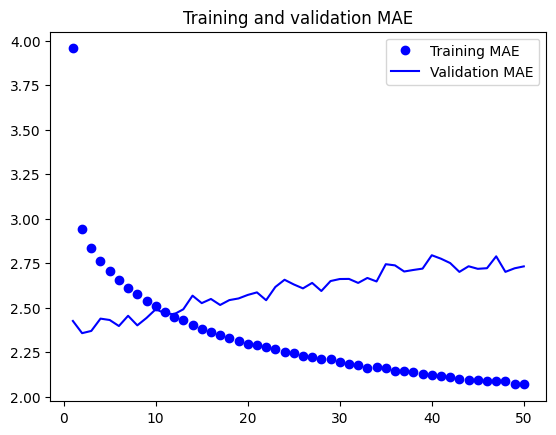

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)  #GRU사용하기 시작 (FULLNAME)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)   
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 52s 59ms/step - loss: 26.4989 - mae: 3.7598 - val_loss: 10.0342 - val_mae: 2.4557
Epoch 2/50
819/819 [==============================] - 47s 58ms/step - loss: 13.4395 - mae: 2.8327 - val_loss: 9.3287 - val_mae: 2.3836
Epoch 3/50
819/819 [==============================] - 47s 57ms/step - loss: 12.4520 - mae: 2.7336 - val_loss: 8.8555 - val_mae: 2.3161
Epoch 4/50
819/819 [==============================] - 54s 65ms/step - loss: 11.8047 - mae: 2.6650 - val_loss: 8.5443 - val_mae: 2.2703
Epoch 5/50
819/819 [==============================] - 48s 58ms/step - loss: 11.1283 - mae: 2.5845 - val_loss: 10.3116 - val_mae: 2.5201
Epoch 6/50
819/819 [==============================] - 54s 66ms/step - loss: 10.4582 - mae: 2.5070 - val_loss: 9.2740 - val_mae: 2.3703
Epoch 7/50
818/819 [============================>.] - ETA: 0s - loss: 9.8285 - mae: 2.4275

KeyboardInterrupt: ignored

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [ ]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets
        
train_gen = train_generator()
val_gen = val_generator()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### 더 나아가서

## 요약